<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


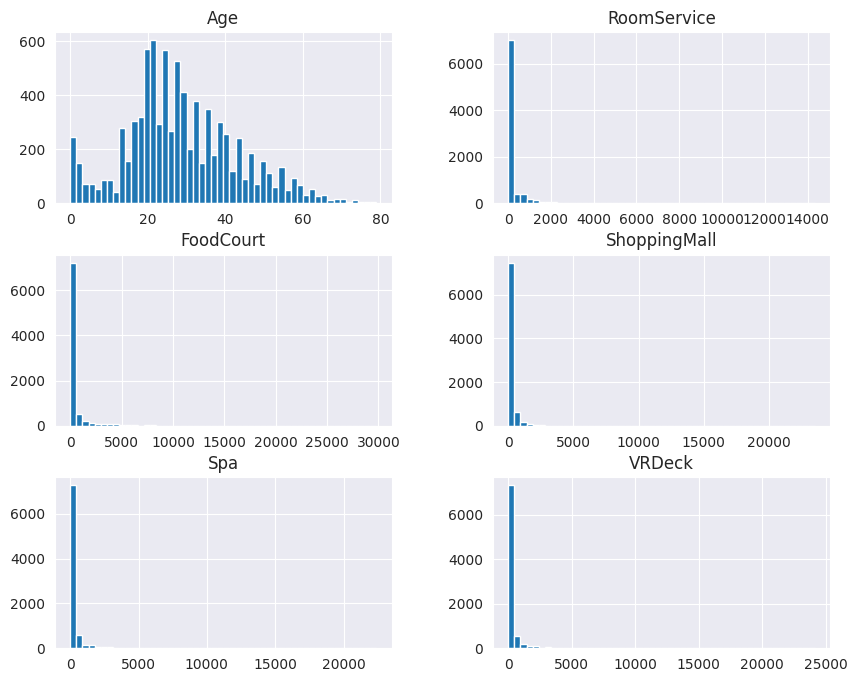

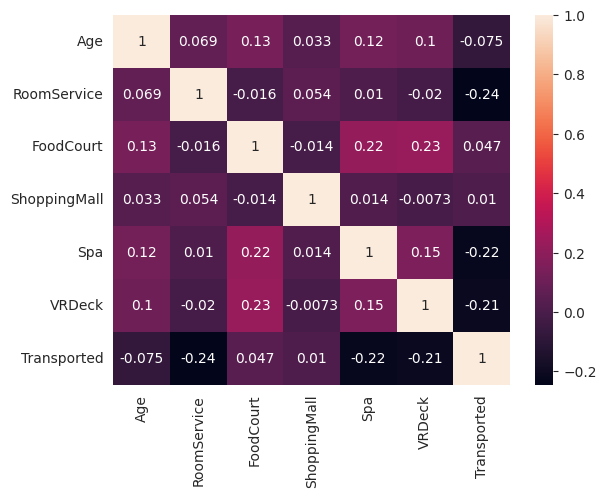

In [8]:
import pandas as pd
%run EDA.ipynb

Split the data into training and validation sets. `y` is the column corresponding to the label and `x` is the variable containing all features.

In [9]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(initial_data.loc[:, initial_data.columns != 'Transported'], initial_data['Transported'], test_size=0.2, random_state=4)

We select 5 models to compare: `linear regression`, `decision tree regressor`, `random forest regressor`, `logistic regression` and `random forest classifier`.
There were chosen such different algorithms (three for regression and two for classification) because there were no graphs showing any visible correlation between any feature and the label. One important hint was the presence of some boolean fields, inclusively the label, that led to choosing the `logistic regression`.
`Decision tree regressor` and `linear regression` are some of the most common models, so I decided to add them, mostly for comparison reasons.
Both `random forest` models were chosen because it is said that they are the best algorithms at this moment.

In [10]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import make_pipeline

# Regression:

# linear regression
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(x_train, y_train)

# decision tree regressor
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(x_train, y_train)

# random forest regressor
rnd_reg = make_pipeline(preprocessing, RandomForestRegressor(n_estimators=500, max_leaf_nodes=13, n_jobs=-1, random_state=42))
rnd_reg.fit(x_train, y_train)

# Classification:

# logistic regression
log_reg = make_pipeline(preprocessing, LogisticRegression(random_state=42))
log_reg.fit(x_train, y_train)

# random forest classifier
rnd_clf = make_pipeline(preprocessing, RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42))
rnd_clf.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['HomePlanet',
                                                   'Destination']),
                                                 ('bool',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['CryoSleep', 'VIP'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_leaf_nodes=16, n_estimators=500,
                                        n_jobs=-1, random_state=42))])

Now, evaluate the performance of the models trained by measuring the `root mean squared error` for regressions and the `accuracy score` for classifications.

In [11]:
from sklearn.metrics import mean_squared_error

In [12]:
lin_rmse = mean_squared_error(y_test, lin_reg.predict(x_test), squared=False)
lin_rmse

0.40792866985423987

In [13]:
tree_rmse = mean_squared_error(y_test, tree_reg.predict(x_test), squared=False)
tree_rmse

0.48379603929288406

In [14]:
rnd_rmse = mean_squared_error(y_test, rnd_reg.predict(x_test), squared=False)
rnd_rmse

0.38254206882536673

In [15]:
from sklearn.metrics import accuracy_score

In [16]:
test_accuracy = accuracy_score(log_reg.predict(x_test), y_test)
test_accuracy

0.7832087406555491

In [17]:
test_accuracy = accuracy_score(rnd_clf.predict(x_test), y_test)
test_accuracy

0.772857964347326

After viewing the results, we decide to stick with the `random forest classifier`.

Now, we fine tune the chosen model for a better performance.

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestClassifier(random_state=42)),
])
full_pipeline.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    ['Age', 'RoomService', 'FoodCourt',
                                     'ShoppingMall', 'Spa', 'VRDeck']),
                                   ('cat',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['HomePlanet', 'Destination']),
               

We change the type of samples because `Random forest classifier` model can't use its default operations on booleans

In [19]:
y_train = y_train.astype(int)
y_test= y_test.astype(int)

In [20]:
param_grid = [
    {'random_forest__max_features': [10, 11, 12],
     'random_forest__max_leaf_nodes': [25, 27, 29, 31]}
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring='accuracy')
grid_search.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_freq...
                                                                         ['HomePlanet',
                                                                          'Destination']),
                                                                        ('bool',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinalencoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['CryoSleep',
                                                                          'VIP'])])),
                                       ('random_forest',
                                        RandomForestClassifier(random_state=42))]),
             param_grid=[{'random_forest__max_features': [10, 11, 12],
                          'random_forest__max_leaf_nodes': [25, 27, 29, 31]}],
             scoring='accuracy')

We found the best hyperparameters for our model. The accuracy raised from 0.783 to 0.807.

In [21]:
test_accuracy = accuracy_score(grid_search.predict(x_test), y_test)
print(test_accuracy)
grid_search.best_params_

0.8073605520414031


{'random_forest__max_features': 12, 'random_forest__max_leaf_nodes': 29}

We save our best pipeline with the resulted hyperparameters

In [22]:
best_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestClassifier(random_state=42, max_features=12, max_leaf_nodes=25)),
])
best_pipeline.fit(x_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['HomePlanet',
                                                   'Destination']),
                                                 ('bool',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['CryoSleep', 'VIP'])])),
                ('random_forest',
                 RandomForestClassifier(max_features=12, max_leaf_nodes=25,
                                        random_state=42))])

Now, let's predict the requested test set.

In [23]:
submission_test_set = pd.read_csv("test.csv")
submission_results = best_pipeline.predict(submission_test_set)
submission_results = submission_results.astype(bool)
type(submission_results)

numpy.ndarray

And generate a submission csv file with the obtained predictions.

In [24]:
submission_dataframe = pd.read_csv('sample_submission.csv')
submission_dataframe['Transported'] = submission_results
submission_dataframe.to_csv('submission_edy_stan.csv', index=False)
submission_dataframe.head()

PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01         True